In [1]:
import model
import os
from option import args
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import data
import utils
import numpy as np
import json
import h5py

number of common Subjects  171


/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dir = "working_models/attempt2"

In [3]:
paths = {}
max_ep = 0
for i in os.listdir(load_dir):
    if "check" not in i and "tensorboard" not in i:
        temp = []
#         print(os.listdir(load_dir + "/" + i))
        for j in os.listdir(load_dir + "/" + i + "/model"):
            temp.append(load_dir + "/" + i + "/model/" + j)
            
            
            _,ep,hfen,psnr = j.split("_")
            ep = int(ep)
            if(max_ep < ep):
                latest_ep_path = load_dir + "/" + i + "/model/" + j
                max_ep = ep
                
            conf = load_dir + "/" + i + "/config.txt"
        paths[i] = (temp,conf,latest_ep_path) 

In [4]:
list_models = list(paths.keys())

In [5]:
paths

{'dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse': (['working_models/attempt2/dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse/model/model_17_0.5126_19.0545.pt',
   'working_models/attempt2/dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse/model/model_3_0.5726_18.2759.pt',
   'working_models/attempt2/dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse/model/model_23_0.5223_19.1911.pt',
   'working_models/attempt2/dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse/model/model_1_0.6519_17.6689.pt',
   'working_models/attempt2/dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse/model/model_4_0.5721_18.4289.pt',
   'working_models/attempt2/dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse/model/model_13_0.5121_19.0155.pt',
   'working_models/attempt2/dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse/model/model_10_0.5

In [6]:
paths[list_models[0]][2]

'working_models/attempt2/dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse/model/model_43_0.5205_19.3642.pt'

In [7]:
paths[list_models[0]][1]

'working_models/attempt2/dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse/config.txt'

In [8]:
list_models

['dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse',
 'dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_0.97*L1+0.03*TV,bs_8,tvTrue']

In [9]:
load_model = list_models[0]

In [10]:
load_model

'dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse'

In [11]:
with open(paths[load_model][1], 'r') as f:
    args.__dict__ = json.load(f)

In [12]:
args.type = args.model_type

In [13]:
# import json
# with open(paths[list_models[0]][1], 'w') as f:
#     json.dump(args.__dict__, f, indent=2)

In [14]:
curr_model = model.Model(args)
curr_model.load(paths[load_model][2])

Making model... here
load from model_working_models/attempt2/dmri_rdn,train_120,test_40,C,False,conv,growth32,loss_1*L1,bs_8,tvFalse/model/model_43_0.5205_19.3642.pt.pt


In [15]:
ids = utils.get_ids()
ids.sort()
offset = 50
args.no_vols,args.test_vols = 2,3
total_vols = args.no_vols+args.test_vols
temp = ids[:args.no_vols]
temp.extend(ids[offset:args.test_vols+offset])
ids = temp
print(ids)

['100610', '102311', '172130', '173334', '175237']


In [16]:
print(len(ids))

5


### Dataloader

In [17]:
loader = data.Data(args,ids= ids)

Loading Done


In [18]:
len(loader.training_dataset)

14

In [19]:
len(next(iter(loader.training_data)))

4

In [20]:
# for batch, (lr,hr,scale,rel_coor) in enumerate(loader.training_data):

#     lr_tensor = lr.squeeze().to('cuda').float()  # ranges from [0, 1]
#     hr_tensor = hr.squeeze().to('cuda').float()  # ranges from [0, 1]
# #     hr = hr.squeeze()
#     rel_coor = rel_coor.squeeze().to('cuda').float()
#     scale = np.asarray(scale[0,:])

#     # print(rel_coor.shape)
#     # tv_tensor = tv.squeeze().to('cuda').float()  # ranges from [0, 1]

#     # print(lr_tensor.shape,hr_tensor.shape,scale)

#     if(len(lr_tensor.shape) == 5):
#         lr = torch.permute(lr_tensor, (0,4,1,2,3))
#     else:
#         lr = torch.permute(lr_tensor, (0,3,1,2))


#     # inference
#     pred = curr_model.forward(lr,scale,rel_coor)
    
#     if(len(lr_tensor.shape) == 5):
#         # print(pred.shape,lr.shape)
#         pred_tensor = torch.permute(pred, (0,2,3,4,1)).float()
#         # pred_tv_tensor = torch.permute(pred_tv, (0,2,3,4,1)).float()
#     else:
#         pred_tensor = torch.permute(pred, (0,2,3,1)).float()
#         # pred_tv_tensor = torch.permute(pred_tv, (0,2,3,1)).float()
            
            
#     break

In [21]:
len(loader.training_dataset)

14

In [22]:
sample = 12
lr,hr,scale,rel_coor = loader.training_dataset[sample]

lr_tensor = lr.squeeze() # ranges from [0, 1]
hr_tensor = hr.squeeze()  # ranges from [0, 1]
rel_coor = rel_coor.squeeze().to('cuda').float()

lr = torch.permute(lr_tensor, (0,4,1,2,3))

lr = lr.to('cuda').float()
pred = curr_model.forward(lr,scale,rel_coor)
    
pred_tensor = torch.permute(pred, (0,2,3,4,1)).float()



pred_tensor = pred_tensor.cpu().detach().numpy()
lr_tensor = lr_tensor.cpu().detach().numpy()

In [23]:
scale

array([1., 1., 1.])

In [46]:
print(f'pred = {pred_tensor.shape}\nhr = {hr_tensor.shape}\nlr = {lr_tensor.shape}')

pred = (8, 32, 8, 32, 5)
hr = (8, 32, 8, 32, 5)
lr = (8, 32, 8, 32, 7)


In [77]:
kernel['x'].shape

torch.Size([1, 1, 3, 3, 3])

In [78]:
kernel['x']

tensor([[[[[-1.,  0.,  1.],
           [-2.,  0.,  2.],
           [-1.,  0.,  1.]],

          [[-2.,  0.,  2.],
           [-4.,  0.,  4.],
           [-2.,  0.,  2.]],

          [[-1.,  0.,  1.],
           [-2.,  0.,  2.],
           [-1.,  0.,  1.]]]]])

In [79]:
inp = torch.permute(torch.from_numpy(pred_tensor), (0,4,1,2,3)).to('cpu')

In [80]:
inp.shape

torch.Size([8, 5, 32, 8, 32])

In [81]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [86]:
temp = F.conv3d(inp[:,0,:,:,:].unsqueeze(1),kernel['x'])

In [88]:
temp.shape

torch.Size([8, 1, 30, 6, 30])

In [89]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from loss.sobel import sobel_3d
kernel = {}
for i in sobel_3d.keys():
    kernel[i] = torch.FloatTensor(sobel_3d[i]).unsqueeze(0).unsqueeze(0)
    
def g2(inp):
    
    inp = torch.permute(torch.from_numpy(inp), (0,4,1,2,3)).to('cpu')
    res = []
    for i in range(inp.shape[1]):
        
        temp = inp[:,i,:,:,:].unsqueeze(1)
    
        x = F.conv3d(temp, kernel['x'])

        y = F.conv3d(temp, kernel['y'])
        
        z = F.conv3d(temp, kernel['z'])

        temp = torch.sqrt((x**2) + (y**2) + (z**2))
        
        x = F.conv3d(temp, kernel['x'])

        y = F.conv3d(temp, kernel['y'])
        
        z = F.conv3d(temp, kernel['z'])

        res.append(torch.sqrt((x**2) + (y**2) + (z**2)))
        
    res = torch.cat(res,dim=1)
    
    return res

In [92]:
pred_temp = g2(pred_tensor)
hr_temp = g2(hr_tensor)


In [93]:
torch.histogram(hr_temp - pred_temp,bins=10)

torch.return_types.histogram(
hist=tensor([1.1000e+01, 4.9000e+01, 9.9000e+01, 4.6500e+02, 2.4030e+03, 7.6265e+04,
        4.2252e+04, 3.4120e+03, 4.3300e+02, 5.1000e+01]),
bin_edges=tensor([-213.3630, -175.6554, -137.9478, -100.2402,  -62.5326,  -24.8249,
          12.8827,   50.5903,   88.2979,  126.0055,  163.7132]))

In [94]:
torch.histogram(pred_temp,bins=10)

torch.return_types.histogram(
hist=tensor([73746., 25432., 14062.,  8002.,  2629.,   792.,   341.,   205.,   157.,
           74.]),
bin_edges=tensor([6.8123e-03, 2.5500e+01, 5.0993e+01, 7.6486e+01, 1.0198e+02, 1.2747e+02,
        1.5296e+02, 1.7846e+02, 2.0395e+02, 2.2944e+02, 2.5494e+02]))

In [95]:
import torch.nn as nn
ls = nn.L1Loss()

In [96]:
ls(pred_temp,hr_temp)

tensor(15.3311)

In [97]:
pred_temp.shape,hr_temp.shape

(torch.Size([8, 5, 28, 4, 28]), torch.Size([8, 5, 28, 4, 28]))

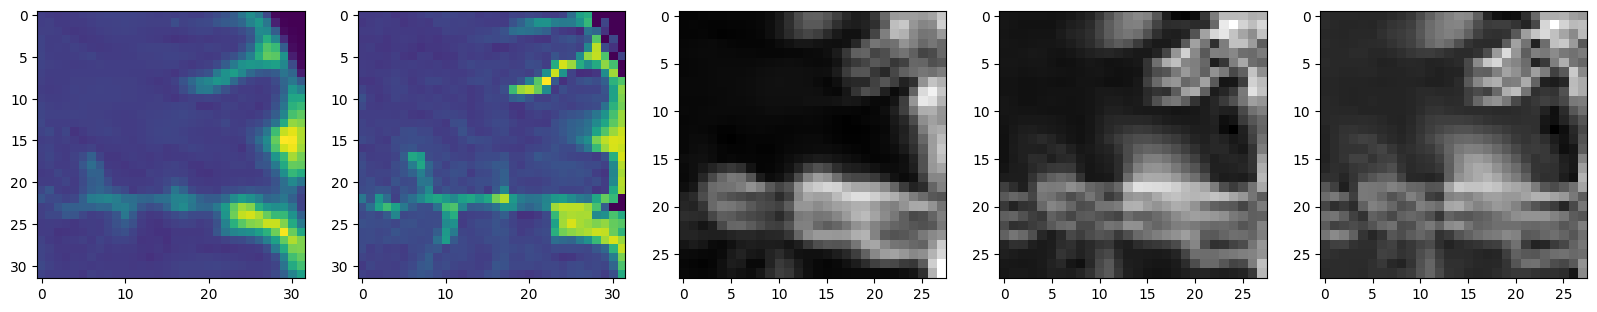

In [104]:
%matplotlib inline

ch = 0

patch = 1



f, axis = plt.subplots(1, 5)
f.set_figwidth(20)
f.set_figheight(10)


axis[0].imshow(pred_tensor[patch,:,0,:,ch])
axis[1].imshow(hr_tensor[patch,:,0,:,ch])
axis[2].imshow(pred_temp[patch,ch,:,0,:].detach().numpy(),cmap = 'gray')
axis[3].imshow(hr_temp[patch,ch,:,0,:].detach().numpy(),cmap = 'gray')
b = hr_temp[patch,ch,:,0,:].detach().numpy() - pred_temp[patch,ch,:,0,:].detach().numpy()
axis[4].imshow(b,cmap = 'gray')




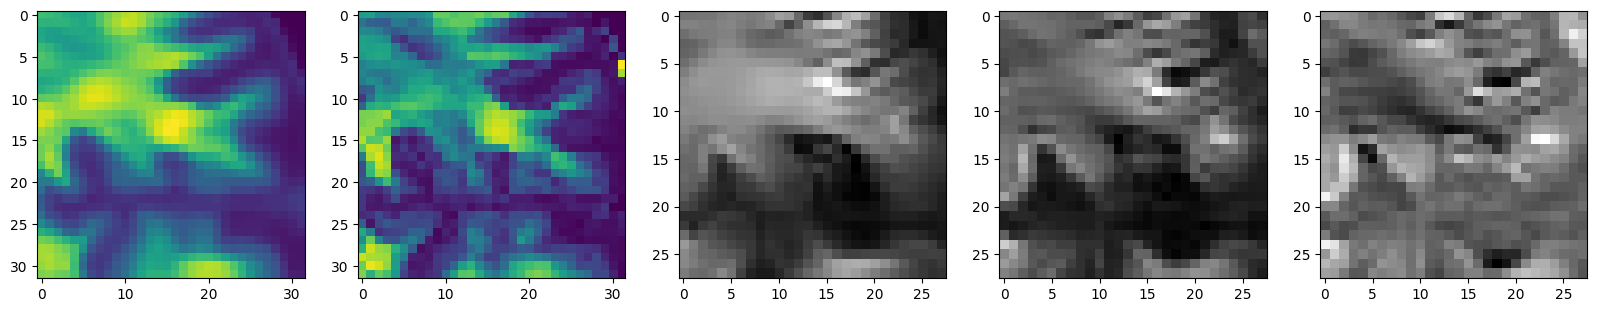

In [105]:
%matplotlib inline

ch = 1

patch = 1



f, axis = plt.subplots(1, 5)
f.set_figwidth(20)
f.set_figheight(10)


axis[0].imshow(pred_tensor[patch,:,0,:,ch])
axis[1].imshow(hr_tensor[patch,:,0,:,ch])
axis[2].imshow(pred_temp[patch,ch,:,0,:].detach().numpy(),cmap = 'gray')
axis[3].imshow(hr_temp[patch,ch,:,0,:].detach().numpy(),cmap = 'gray')
b = hr_temp[patch,ch,:,0,:].detach().numpy() - pred_temp[patch,ch,:,0,:].detach().numpy()
axis[4].imshow(b,cmap = 'gray')




In [99]:
ch = 1
patch = 1



f, axis = plt.subplots(1, 5)
f.set_figwidth(20)
f.set_figheight(10)


axis[0].imshow(pred_tensor[patch,:,0,:,ch])
axis[1].imshow(hr_tensor[patch,:,0,:,ch])
axis[2].imshow(pred_temp[patch,ch,:,0,:].detach().numpy(),cmap = 'gray')
axis[3].imshow(hr_temp[patch,ch,:,0,:].detach().numpy(),cmap = 'gray')
b = hr_temp[patch,ch,:,0,:].detach().numpy() - pred_temp[patch,ch,:,0,:].detach().numpy()
axis[4].imshow(b,cmap = 'gray')


pred_temp.shape

torch.Size([8, 5, 28, 4, 28])

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

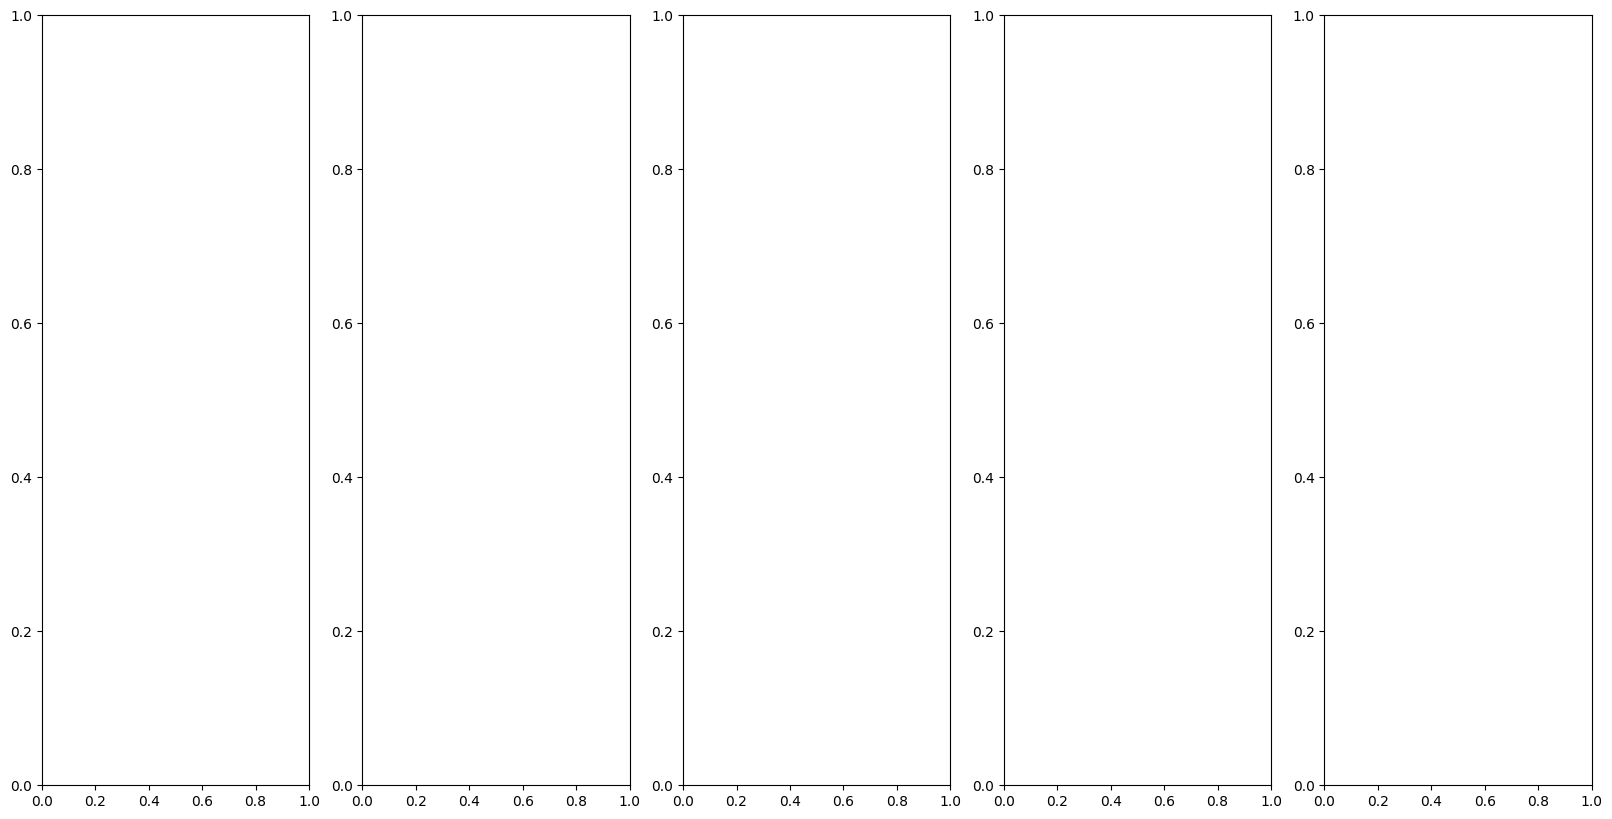

In [113]:
ch = 1
patch = 4



f, axis = plt.subplots(1, 5)
f.set_figwidth(20)
f.set_figheight(10)

axis[0].imshow(pred_tensor.cpu().detach().numpy()[patch,:,:,0,ch])
axis[1].imshow(hr_tensor.cpu().detach().numpy()[patch,:,:,0,ch])
axis[2].imshow(pred_temp[patch,ch,:,:,0].detach().numpy(),cmap = 'gray')
axis[3].imshow(hr_temp[patch,ch,:,:,0].detach().numpy(),cmap = 'gray')
b = hr_temp[patch,ch,:,:,0].detach().numpy() - pred_temp[patch,ch,:,:,0].detach().numpy()
axis[4].imshow(b,cmap = 'gray')




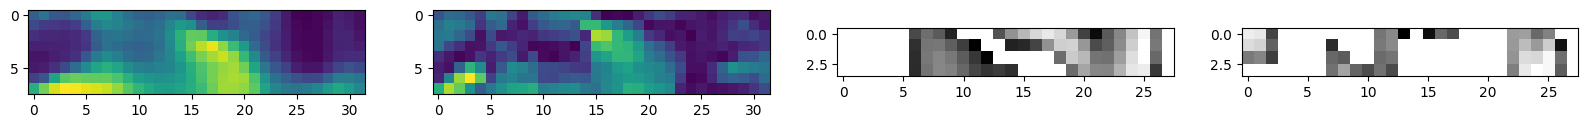

In [95]:
ch = 4
patch = 0



f, axis = plt.subplots(1, 4)
f.set_figwidth(20)
f.set_figheight(10)

axis[0].imshow(pred_tensor.cpu().detach().numpy()[patch,:,:,0,ch])
axis[1].imshow(hr_tensor.cpu().detach().numpy()[patch,:,:,0,ch])
axis[2].imshow(pred_temp[patch,ch,:,:,0].detach().numpy(),cmap = 'gray')
axis[3].imshow(hr_temp[patch,ch,:,:,0].detach().numpy(),cmap = 'gray')




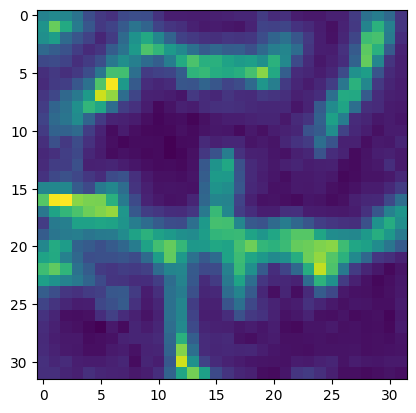

In [47]:
plt.imshow(pred_tensor.cpu().detach().numpy()[0,:,:,0,0])

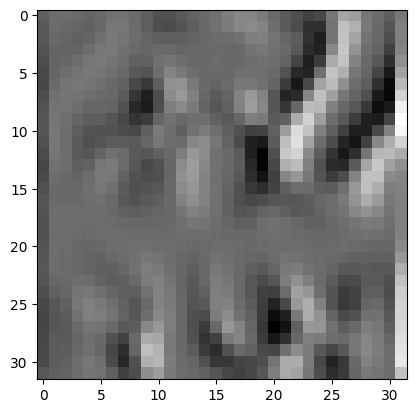

In [51]:
plt.imshow(pred_temp.cpu().detach().numpy()[0,0,:,:,0],cmap='gray')

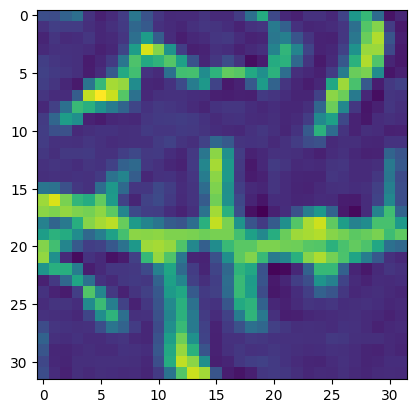

In [25]:
plt.imshow(hr_tensor.cpu().detach().numpy()[0,:,:,0,0])

In [37]:
print(sobel_kernel.shape) 

torch.Size([1, 5, 3, 3, 3])


In [49]:
pred_temp.shape

torch.Size([8, 1, 32, 32, 8])

In [46]:
pred_temp

tensor([[[[[-1.1773e+00, -1.3904e+00, -8.7272e-01,  ...,  9.5381e-04,
             7.9754e-03,  1.1209e-02],
           [ 5.6387e-02, -3.5958e-01, -8.2009e-01,  ...,  1.6632e-03,
             1.2394e-02,  5.6501e-03],
           [ 6.6147e-02, -6.4614e-02, -5.8574e-01,  ..., -2.4532e-02,
            -7.9364e-03, -5.6219e-03],
           ...,
           [-7.6420e-02, -1.0070e-01, -1.7976e-01,  ..., -5.0293e-02,
             1.4102e-01,  1.9222e-01],
           [-1.1061e+00, -1.7945e+00, -2.2409e+00,  ..., -7.0450e-01,
            -1.1114e-01,  4.9655e-02],
           [ 1.1300e+00,  1.5252e+00,  1.5986e+00,  ...,  1.4630e+00,
             1.4265e+00,  1.0536e+00]],

          [[-1.7313e+00, -2.1357e+00, -1.4609e+00,  ...,  2.8677e-03,
             1.1945e-02,  1.6227e-02],
           [ 1.8418e-03, -4.7286e-01, -1.1025e+00,  ...,  7.4622e-03,
             1.9233e-02,  9.6013e-03],
           [-1.3710e-01, -1.8577e-01, -7.7488e-01,  ..., -8.8274e-02,
            -1.1062e-02, -5.8503e-03],
 

### DCELoss

In [178]:
import torch
import torch.nn as nn
import numpy as np
import math
from torch import linalg as LA

class DCELoss(nn.Module):
    def __init__(self):
        super(DCELoss,self).__init__()


    def forward(self,pred,hr):
        S_srhr = torch.zeros((8,8))
        S_srsr = torch.zeros((8,8))
        M = torch.zeros((8,8))
        pred_temp = pred.reshape(8,temp)
        hr_temp = hr.reshape(8,temp)
        for i in range(8):
            for j in range(8):
                S_srhr[i][j] = torch.dot(pred_temp[i],hr_temp[j])/(LA.norm(pred_temp[i])* LA.norm(hr_temp[j]))
                S_srsr[i][j] = torch.dot(pred_temp[i],pred_temp[j])/(LA.norm(pred_temp[i])* LA.norm(pred_temp[j]))
                M[i][j] = min((-20)*torch.log10(LA.norm(hr_temp[i] - hr_temp[j])),0)
                
        Q_pos = torch.zeros((8))
        Q_neg = torch.zeros((8))
        n_thres = M.median()
        t_pos,t_neg = 0.5,0.5
        for i in range(8):
            for j in range(8):
                if( abs(M[i][j]) > abs(n_thres)):
                    Q_pos[i] +=  (( torch.exp(S_srsr[i][j]) + (2*torch.exp(S_srhr[i][j])) ) /t_pos )
                else:
                    Q_neg[i] += (( torch.exp(S_srsr[i][j]) + (2*torch.exp(S_srhr[i][j])) ) /t_neg )
                
        los = (-1/8) * torch.log(Q_pos/Q_neg).sum()
        
        return los

In [179]:
loss_fn = DCELoss()

In [180]:
loss_fn(pred_tensor,hr_tensor)

tensor(0.1657, grad_fn=<MulBackward0>)

In [177]:
float(metrics.peak_signal_noise_ratio(hr,pred,data_range=1))

ValueError: Input images must have the same dimensions.

In [126]:

for i in range(8):
    for j in range(8):

In [130]:
mean(M)

NameError: name 'mean' is not defined

In [133]:
M.mean()

tensor(-27.0891)

In [141]:
M.median(),M.mean()

(tensor(-30.9380), tensor(-27.0891))

In [143]:
M[M>M.median()]

tensor([  0.0000, -30.0437, -30.5460, -30.4371, -30.5017, -30.9214, -30.0437,
          0.0000, -30.7547, -30.5460, -30.7547,   0.0000,   0.0000, -29.1075,
        -30.7632, -28.8074, -30.4371,   0.0000, -30.4007, -29.1075,   0.0000,
        -29.2137, -30.5017, -30.7632, -30.4007,   0.0000, -30.3235, -30.9214,
        -28.8074, -29.2137, -30.3235,   0.0000])